<a href="https://colab.research.google.com/github/wvirany/mini_projects/blob/main/double_descent/MNIST_double_descent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.interpolate import make_interp_spline, BSpline

from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, zero_one_loss
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings("ignore")

In [55]:
# Fetching the data from sklearn.datasets:

dataset = datasets.fetch_openml('mnist_784',
                                version=1,
                                as_frame=True,
                                return_X_y=True,
                                parser='auto')

In [63]:
X, y = dataset

num_samples = 12600

In [64]:
X = np.array(X).reshape(70000, 784) / 255.0
y = np.array(y, dtype='int')

X = X[:num_samples, :]
y = y[:num_samples]

y = pd.get_dummies(y).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42, stratify=y)

In [65]:
print(f'Training samples: {X_train.shape[0]}\nTest samples: {X_test.shape[0]}')

Training samples: 10080
Test samples: 2520


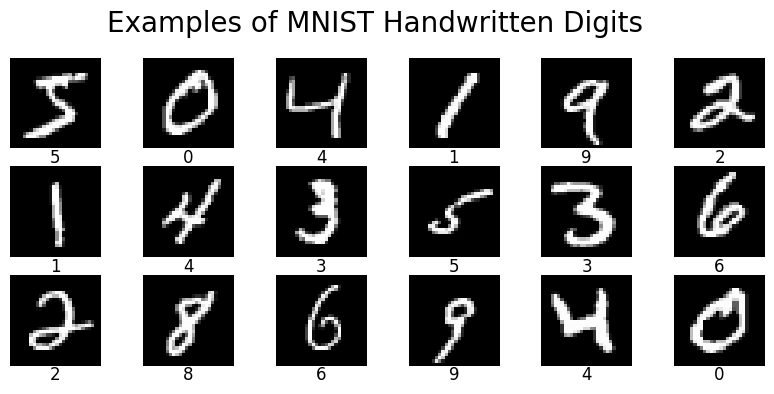

In [66]:
fig, axes = plt.subplots(nrows=3, ncols = 6, figsize=(10, 4))

for i in range(3):
  for j in range(6):
    axes[i, j].axis('off')
    axes[i, j].imshow(X[8*i+j].reshape(28, 28), cmap='gray')
    axes[i, j].set_title(np.argmax(y[8*i+j]), y=-.25)

fig.suptitle('Examples of MNIST Handwritten Digits', y=1, fontsize=20);

## Random Forest

In [76]:
train_loss = []
test_loss = []

for i in range(2, 2000, 50):

  rf = RandomForestClassifier(n_estimators=1,
                              max_leaf_nodes=i,
                              random_state=1)

  rf.fit(X_train, y_train)

  train_pred = rf.predict(X_train)
  test_pred = rf.predict(X_test)

  train_loss.append(zero_one_loss(y_train, train_pred))
  test_loss.append(zero_one_loss(y_test, test_pred))

for i in range(1, 30):

  rf = RandomForestClassifier(n_estimators=i,
                              max_leaf_nodes=2000,
                              random_state=1)

  rf.fit(X_train, y_train)

  train_pred = rf.predict(X_train)
  test_pred = rf.predict(X_test)

  train_loss.append(zero_one_loss(y_train, train_pred))
  test_loss.append(zero_one_loss(y_test, test_pred))

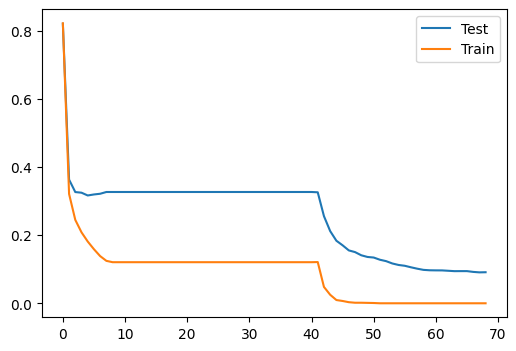

In [77]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(test_loss, label='Test')
ax.plot(train_loss, label='Train')

# plt.xscale('log')

ax.legend();

Here I am able to reproduce the double descent curve; however, a question still remains: is this the true double descent phenomenon?

I think that we are restraining the model complexity until the point when we begin increasing the number of estimators, but is this really an example of double descent?

## AdaBoost

In [78]:
X, y = dataset

num_samples = 12600

In [79]:
X = np.array(X).reshape(70000, 784) / 255.0
y = np.array(y, dtype='int')

X = X[:num_samples, :]
y = y[:num_samples]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.8, random_state=42, stratify=y)

In [93]:
train_loss = []
test_loss = []

base_estimator = DecisionTreeClassifier(max_depth=8)

for i in range(1, 100, 2):

  clf = AdaBoostClassifier(estimator=base_estimator, n_estimators=i, random_state=42)

  clf.fit(X_train, y_train)

  train_pred = clf.predict(X_train)
  test_pred = clf.predict(X_test)

  train_loss.append(zero_one_loss(y_train, train_pred))
  test_loss.append(zero_one_loss(y_test, test_pred))

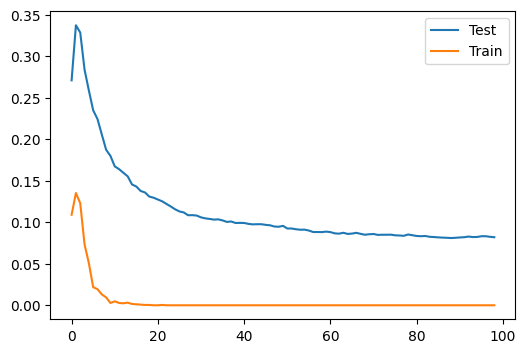

In [94]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(test_loss, label='Test')
ax.plot(train_loss, label='Train')

# plt.xscale('log')

ax.legend();

Interestingly, even though AdaBoost achieves interpolation at around 20 estimators, the test loss continues to decrease as the complexity of the AdaBoost classifier is increased to 100 estimators.